In [1]:
import numpy as np
import xgboost as xgb
import pandas as pd
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot
from joblib import dump
from joblib import load
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_tree
from time import time
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import graphviz

In [32]:
# load data

data = read_csv('D:/Kuliah/TA/DATAGABUNG4.csv', header=None)
dataset = data.values

# split data into X and y

X = dataset[1:,:-1]
Y = dataset[1:,-1]
Y = Y.astype(str)

print(data.head())

        0          1          2           3
0  Normal  Signature  Dangerous       Jenis
1       3          0          4  Trojan-SMS
2       3          0          5  Trojan-SMS
3       5          2          6    RiskTool
4      11          3         10    RiskTool


In [16]:
#encode string Y as integers

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_Y = label_encoder.transform(Y)
print (label_encoded_Y)
list(label_encoder.inverse_transform([3]))

[6 6 2 ... 1 1 1]


['Trojan']

In [33]:
#split dataset to train and test as 80% 20%
seed = 8
test_size = 0.2 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# xgtrain = xgb.DMatrix(X_train, y_train)
# xgtest = xgb.DMatrix(X_test , y_test)

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 1000)

X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train.ravel())

In [34]:
hasil = pd.Series(y_train).value_counts()

Text(0, 0.5, 'Jumlah Data')

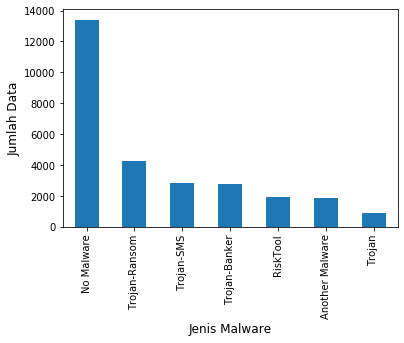

In [35]:
hasil.plot.bar().set_xlabel("Jenis Malware", fontsize=12)
hasil.plot.bar().set_ylabel("Jumlah Data", fontsize=12)

In [35]:
# fit model no training data with default parameters
model = XGBClassifier(
    subsample= 0.4, scale_pos_weight= 100, reg_lambda= 3,reg_alpha= 0.5, n_estimators= 100, min_child_weight= 1, max_depth= 7, learning_rate= 0.1, gamma= 2, colsample_bytree= 1.0
#     n_jobs=-1, max_depth=4
#                         subsample= 0.4, reg_lambda= 2, reg_alpha= 0, n_estimators= 200, min_child_weight= 7, max_depth= 7, learning_rate= 0.1, gamma= 2, colsample_bytree= 0.8
                     )
model.fit(X_train_SMOTE, y_train_SMOTE)
#save model
dump(model, "D:/Kuliah/TA/TA_model.sav")
print(model)
# make predictions for test data
y_pred = model.predict(X_test) 
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.5, reg_lambda=3, scale_pos_weight=100, seed=None,
              silent=None, subsample=0.4, verbosity=1)
Accuracy: 60.81%


In [32]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

xgb_clf = XGBClassifier( objective = "multi:softmax")
# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 150, 200, 250, 300]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",cv = 10, verbose = 3, random_state = 40)


start = time()
# Fit the model
model_xgboost = xgb_rscv.fit(X_train_SMOTE, y_train_SMOTE)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(model_xgboost.cv_results_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.584, total= 1.4min
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.594, total= 1.3min
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.581, total= 1.4min
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.590, total= 1.4min
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.596, total= 1.4min
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=200, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsampl

[CV]  subsample=0.4, reg_lambda=4.5, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8, score=0.688, total= 3.0min
[CV] subsample=0.4, reg_lambda=4.5, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8 
[CV]  subsample=0.4, reg_lambda=4.5, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8, score=0.692, total= 3.1min
[CV] subsample=0.4, reg_lambda=4.5, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8 
[CV]  subsample=0.4, reg_lambda=4.5, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8, score=0.686, total= 3.1min
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[CV]  subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=200, min_child_weight=5, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=0.8, score=0.482, total=  58.7s
[CV] subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=200, min_child_weight=5, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=0.8 
[CV]  subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=200, min_child_weight=5, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=0.8, score=0.490, total=  59.1s
[CV] subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=200, min_child_weight=5, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=0.8 
[CV]  subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=200, min_child_weight=5, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=0.8, score=0.487, total=  59.1s
[CV] subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=200, min_child_weight=5, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=0.8 
[CV]

[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3, score=0.501, total= 1.3min
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3, score=0.491, total= 1.3min
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=300, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3, score=0.486, total= 1.3min
[CV] subsample=0.7, reg_lambda=1, reg_alpha=0.5, n_estimators=150, min_child_weight=1, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6 
[CV]  subsample

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 144.0min finished


NameError: name 'n_iter_search' is not defined

In [33]:
report(model_xgboost.cv_results_)

Model with rank: 1
Mean validation score: 0.690 (std: 0.006)
Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 1.0}

Model with rank: 2
Mean validation score: 0.685 (std: 0.007)
Parameters: {'subsample': 0.4, 'reg_lambda': 4.5, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}

Model with rank: 3
Mean validation score: 0.638 (std: 0.007)
Parameters: {'subsample': 0.5, 'reg_lambda': 4.5, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}

Model with rank: 4
Mean validation score: 0.604 (std: 0.007)
Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.001, 'gamma': 2, 'colsample_bytree': 0.8}

Mode